In [86]:
import os
import numpy as np
import cv2
from skimage import color, segmentation
from skimage.filters import gabor
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
from skimage.measure import regionprops

In [87]:
# Directories
work_dir = "/Users/emre/GitHub/HU-AI/AIN432/Assignment 3"
DATA_PATH = os.path.join(work_dir, "data")
PROCESSED_PATH = os.path.join(DATA_PATH, "processed")
INTERIM_PATH = os.path.join(DATA_PATH, "interim")
RAW_PATH = os.path.join(DATA_PATH, "raw")
MODELS_PATH = os.path.join(work_dir, "models")
GRAPH_PATH = os.path.join(work_dir, "graphs")
OUTPUTS_PATH = os.path.join(work_dir, "outputs")

In [88]:
def read_directory(directory_name, file_extension=".png"):
    return sorted(
        [file for file in os.listdir(directory_name) if file.endswith(file_extension)]
    )

In [89]:
def create_directory(workdir, directory_name):
    if not os.path.exists(os.path.join(workdir, directory_name)):
        os.makedirs(os.path.join(workdir, directory_name))

In [90]:
def save_graphs(workdir, directory_name, graphname, plt):
    filename = os.path.join(workdir, directory_name, graphname)

    if not os.path.isfile(filename):
        create_directory(workdir, directory_name)
        plt.savefig(filename)

In [91]:
def read_images(work_dir, image_paths):
    images = {}
    for image_path in image_paths:
        # check if image exist
        if not os.path.isfile(os.path.join(work_dir, image_path)):
            print("Image not found: ", image_path)
            continue

        # read image
        img = cv2.imread(os.path.join(work_dir, image_path))
        # cobvert to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images[image_path] = img

    return images

In [92]:
def show_images(images, title="Images"):
    images_len = len(images)
    cols = 3
    rows = images_len // cols + (images_len % cols > 0)

    fig, ax = plt.subplots(rows, cols, figsize=(9, 3 * rows))
    fig.suptitle(title)
    fig.tight_layout()

    axes = ax.ravel() if images_len > cols else [ax]

    if type(images) is dict:  # noqa: E721
        for i, (image_name, image) in enumerate(images.items()):
            axes[i].imshow(image, aspect="auto")
            axes[i].set_title(image_name, fontsize=8)
            # axes[i].axis("off")

    else:
        for i, image in enumerate(images):
            axes[i].imshow(image, aspect="auto")
            axes[i].axis("off")

    # Hide any unused subplots
    for j in range(i + 1, rows * cols):
        axes[j].axis("off")

    save_graphs(work_dir, "graphs", title + ".png", plt)
    plt.show()

In [93]:
def resize_images(images, size, file_extension=".png", save_imgs=False, save_dir=None):
    resized_images = {}
    for image_name, image in images.items():
        resized_image = cv2.resize(image, size)
        resized_images[image_name] = resized_image
        resized_image = cv2.cvtColor(resized_image, cv2.COLOR_RGB2BGR)

        if save_imgs:
            if not os.path.exists(save_dir):
                os.makedirs(save_dir)

            new_image_name = image_name.replace(
                file_extension, f"{size}_resized{file_extension}"
            )

            # Use cv2.IMWRITE_PNG_COMPRESSION for PNG images
            # Use cv2.IMWRITE_JPEG_QUALITY for JPEG images
            save_params = None
            if file_extension.lower() == ".png":
                save_params = [
                    cv2.IMWRITE_PNG_COMPRESSION,
                    9,
                ]  # Adjust compression level (0-9)
            elif file_extension.lower() == ".jpg" or file_extension.lower() == ".jpeg":
                save_params = [
                    cv2.IMWRITE_JPEG_QUALITY,
                    95,
                ]  # Adjust JPEG quality (0-100)

            cv2.imwrite(
                os.path.join(save_dir, new_image_name), resized_image, save_params
            )

    return resized_images

In [94]:
def normalize_feature(feature):
    # Normalize feature values to the same value interval (0 to 1)
    return (feature - np.min(feature)) / (np.max(feature) - np.min(feature))

In [95]:
def extract_rgb_color_feature(image):
    # Extract RGB color feature for each pixel
    return normalize_feature(image.reshape((-1, 3)))

In [96]:
def extract_pixel_features(image):
    # Extract RGB color and spatial location feature for each pixel
    h, w, _ = image.shape
    x, y = np.meshgrid(np.arange(w), np.arange(h))
    spatial_location = np.column_stack((x.flatten(), y.flatten()))
    return normalize_feature(np.hstack((image.reshape((-1, 3)), spatial_location)))

In [97]:
def extract_superpixels(
    image,
    raw_image,
    num_segments,
    show_superpixels=False,
    savefig=False,
    img_name: str = "",
):
    # Use SLIC Superpixel method to extract superpixels
    segments = segmentation.slic(
        image, n_segments=num_segments, compactness=10, sigma=1
    )

    if show_superpixels:
        fig, ax = plt.subplots(1, 2, figsize=(8, 4))
        plt.suptitle(f"Superpixels {img_name}")
        ax[0].imshow(segmentation.mark_boundaries(image, segments))
        ax[0].set_title("Original Image")
        ax[1].imshow(segments)
        ax[1].set_title("Superpixels")
        plt.tight_layout()
        plt.show()

    if savefig:
        fig, ax = plt.subplots(1, 2, figsize=(8, 4))
        plt.suptitle(f"Superpixels {img_name}")
        ax[0].imshow(segmentation.mark_boundaries(image, segments))
        ax[0].set_title("Original Image")
        ax[1].imshow(segments)
        ax[1].set_title("Superpixels")
        plt.tight_layout()

        filename = img_name + "_superpixels.png"
        save_graphs(work_dir, "graphs", filename, plt)

    return segments

In [98]:
def extract_mean_rgb_superpixel_feature(
    image, superpixels, showfig: bool = False, savefig: bool = False, img_name: str = ""
):
    # Extract mean RGB color values for each superpixel
    mean_rgb_features = np.zeros((np.max(superpixels), 3))

    for i in range(3):  # iterate over RGB channels
        for idx, prop in enumerate(
            regionprops(superpixels, intensity_image=image[:, :, i])
        ):
            mean_rgb_features[idx, i] = prop.mean_intensity

    if showfig:
        plt.figure(figsize=(4, 4))
        plt.suptitle(f"Mean RGB {img_name}")
        plt.imshow(mean_rgb_features, aspect="auto")
        plt.title("Mean RGB Features")
        plt.xlabel("RGB Channel")
        plt.ylabel("Superpixel Index")
        plt.tight_layout()
        plt.show()

    if savefig:
        plt.figure(figsize=(4, 4))
        plt.suptitle(f"Mean RGB {img_name}")
        plt.imshow(mean_rgb_features, aspect="auto")
        plt.title("Mean RGB Features")
        plt.xlabel("RGB Channel")
        plt.ylabel("Superpixel Index")
        plt.tight_layout()

        filename = img_name + "_mean_rgb_features.png"
        save_graphs(work_dir, "graphs", filename, plt)

    return normalize_feature(mean_rgb_features)

In [99]:
def extract_rgb_histogram_superpixel_feature(
    image,
    superpixels,
    showfig: bool = False,
    savefig: bool = False,
    img_name: str = "",
):
    # Extract RGB color histogram for each superpixel
    rgb_histogram_features = np.zeros((np.max(superpixels), 3))

    for i in range(3):  # iterate over RGB channels
        for idx, prop in enumerate(
            regionprops(superpixels, intensity_image=image[:, :, i])
        ):
            rgb_histogram_features[idx, i] = prop.mean_intensity

    if showfig:
        plt.figure(figsize=(4, 4))
        plt.suptitle(f"Histogram {img_name}")
        plt.imshow(rgb_histogram_features, aspect="auto")
        plt.title("RGB Histogram Features")
        plt.xlabel("RGB Channel")
        plt.ylabel("Superpixel Index")
        plt.tight_layout()
        plt.show()

    if savefig:
        plt.figure(figsize=(4, 4))
        plt.suptitle(f"Histogram {img_name}")
        plt.imshow(rgb_histogram_features, aspect="auto")
        plt.title("RGB Histogram Features")
        plt.xlabel("RGB Channel")
        plt.ylabel("Superpixel Index")
        plt.tight_layout()

        filename = img_name + "_rgb_histogram_features.png"
        save_graphs(work_dir, "graphs", filename, plt)

    return normalize_feature(rgb_histogram_features)

In [100]:
def convert_save_df(
    data: dict, titles: list, filepath: str, prename: str = "", show_head: bool = True
):
    if not os.path.exists(filepath):
        os.makedirs(filepath)

    for key in data:
        df = pd.DataFrame(data[key], columns=titles)
        if show_head:
            print(key)
            display(df.head())

        filename = os.path.join(filepath, prename + key.split(".")[0] + ".parquet")

        # check i file exist
        if os.path.isfile(filename):
            print("File already exist: ", filename)
            continue

        df.to_parquet(filename, index=False)

In [101]:
def gabor_features_superpixel(
    image, superpixels, frequencies=(0.1, 0.5), angles=(0, 1, 2, 3)
):
    # Convert the RGB image to grayscale
    gray_image = color.rgb2gray(image)

    # Calculate Gabor filter responses for different scales and orientations
    gabor_responses = []
    for freq in frequencies:
        for angle in angles:
            gabor_filter = np.real(
                gabor(gray_image, frequency=freq, theta=np.pi / 4 * angle)[0]
            )
            gabor_responses.append(gabor_filter)

    gabor_responses = np.array(gabor_responses)

    # Initialize an array to store mean Gabor features for each superpixel
    mean_gabor_features_superpixel = np.zeros(
        (np.max(superpixels), gabor_responses.shape[0])
    )

    # Iterate over superpixels
    for idx, prop in enumerate(regionprops(superpixels)):
        pixels_in_superpixel = superpixels == (
            idx + 1
        )  # Regionprops indexing starts from 1
        mean_gabor_features_superpixel[idx] = np.mean(
            gabor_responses[:, pixels_in_superpixel], axis=1
        )

    return normalize_feature(mean_gabor_features_superpixel)

In [102]:
def extract_superpixel_features(image, img_name: str = ""):
    image_xyz = color.rgb2xyz(image)
    # Extract mean RGB color values and RGB color histogram for each superpixel
    superpixels = extract_superpixels(
        image_xyz,
        raw_image=image,
        num_segments=100,
        show_superpixels=False,
        savefig=True,
        img_name=img_name,
    )

    mean_rgb_features = extract_mean_rgb_superpixel_feature(
        image,
        superpixels,
        showfig=False,
        savefig=True,
        img_name=img_name,
    )

    rgb_histogram_features = extract_rgb_histogram_superpixel_feature(
        image,
        superpixels,
        showfig=False,
        savefig=True,
        img_name=img_name,
    )

    gabor_superpixel_features = gabor_features_superpixel(image, superpixels)

    return np.hstack(
        (mean_rgb_features, rgb_histogram_features, gabor_superpixel_features)
    )

In [103]:
def excract_features(images: dict, feature_extractor: str):
    features = {}

    if feature_extractor == "pixel_features":
        for img_name in images:
            features[img_name] = extract_pixel_features(images[img_name])

    if feature_extractor == "superpixel_features":
        for img_name in images:
            features[img_name] = extract_superpixel_features(
                images[img_name],
                img_name.split(".")[0],
            )

    return features

In [104]:
def main():
    IMAGE_SIZE = (1024, 1024)

    # read images from directory
    image_paths = read_directory(RAW_PATH, file_extension=".jpg")
    images = read_images(RAW_PATH, image_paths)

    # resize images
    resized_images = resize_images(
        images, IMAGE_SIZE, save_imgs=True, save_dir=INTERIM_PATH, file_extension=".jpg"
    )

    # show resized images
    # show_images(resized_images, f"Resized Images ({IMAGE_SIZE})")

    df_pixel = excract_features(resized_images, feature_extractor="pixel_features")
    convert_save_df(
        df_pixel, ["R", "G", "B", "X", "Y"], PROCESSED_PATH, show_head=False
    )

    df_superpixel = excract_features(
        resized_images, feature_extractor="superpixel_features"
    )
    convert_save_df(
        df_superpixel,
        [
            "Mean R",
            "Mean G",
            "Mean B",
            "R Histogram",
            "G Histogram",
            "B Histogram",
            "Gabor 0.1 0",
            "Gabor 0.1 1",
            "Gabor 0.1 2",
            "Gabor 0.1 3",
            "Gabor 0.5 0",
            "Gabor 0.5 1",
            "Gabor 0.5 2",
            "Gabor 0.5 3",
        ],
        PROCESSED_PATH,
        prename="superpixel_",
        show_head=False,
    )

File already exist:  /Users/emre/GitHub/HU-AI/AIN432/Assignment 3/data/processed/abhishek-hajare.parquet
File already exist:  /Users/emre/GitHub/HU-AI/AIN432/Assignment 3/data/processed/alina-karpenko.parquet
File already exist:  /Users/emre/GitHub/HU-AI/AIN432/Assignment 3/data/processed/daria-stark.parquet
File already exist:  /Users/emre/GitHub/HU-AI/AIN432/Assignment 3/data/processed/diana-polekhina.parquet
File already exist:  /Users/emre/GitHub/HU-AI/AIN432/Assignment 3/data/processed/luisana-zerpa.parquet


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


File already exist:  /Users/emre/GitHub/HU-AI/AIN432/Assignment 3/data/processed/superpixel_abhishek-hajare.parquet
File already exist:  /Users/emre/GitHub/HU-AI/AIN432/Assignment 3/data/processed/superpixel_alina-karpenko.parquet
File already exist:  /Users/emre/GitHub/HU-AI/AIN432/Assignment 3/data/processed/superpixel_daria-stark.parquet
File already exist:  /Users/emre/GitHub/HU-AI/AIN432/Assignment 3/data/processed/superpixel_diana-polekhina.parquet
File already exist:  /Users/emre/GitHub/HU-AI/AIN432/Assignment 3/data/processed/superpixel_luisana-zerpa.parquet


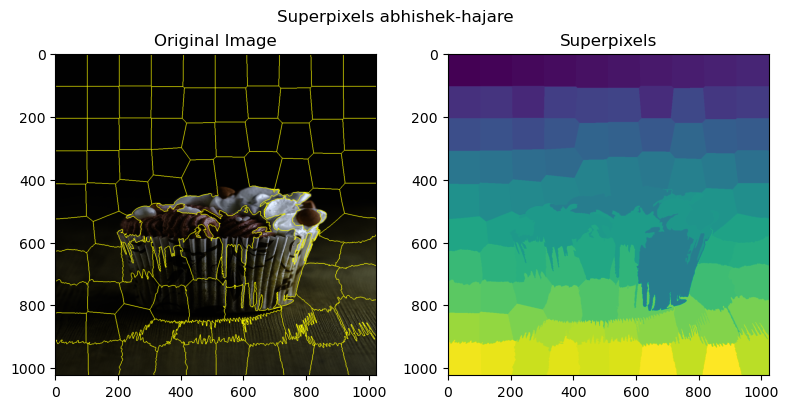

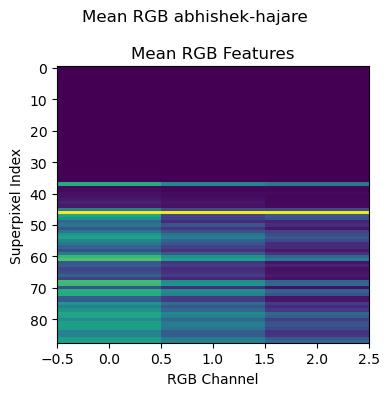

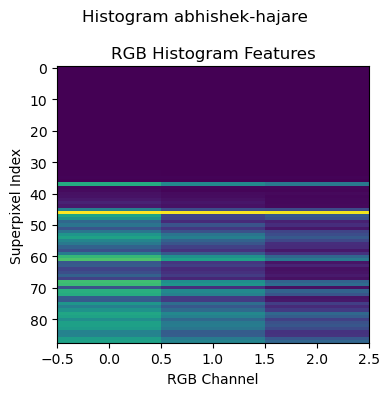

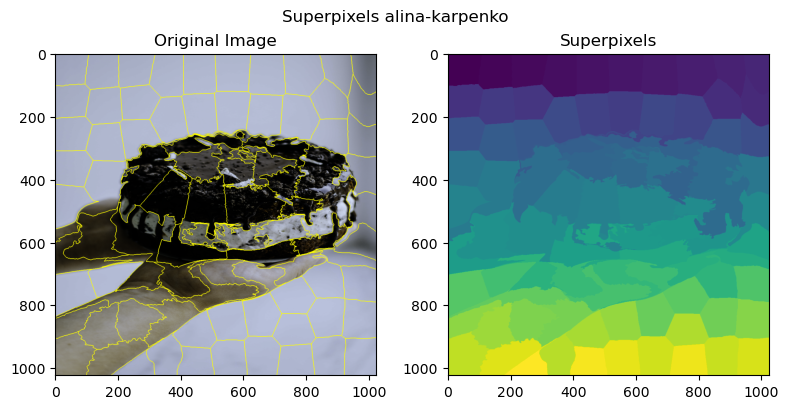

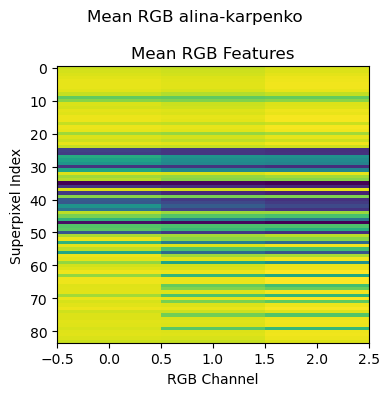

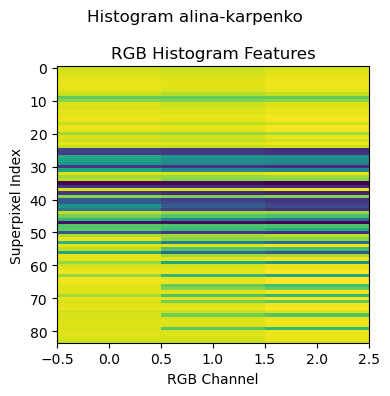

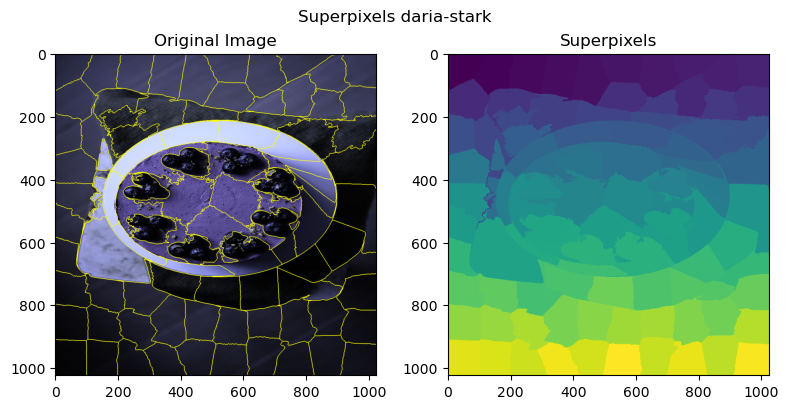

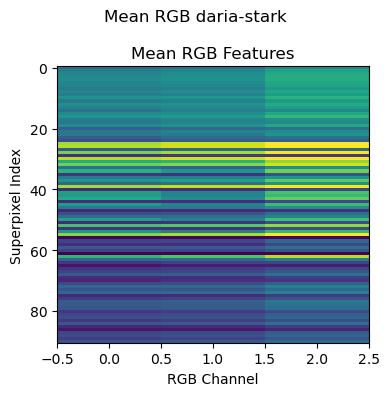

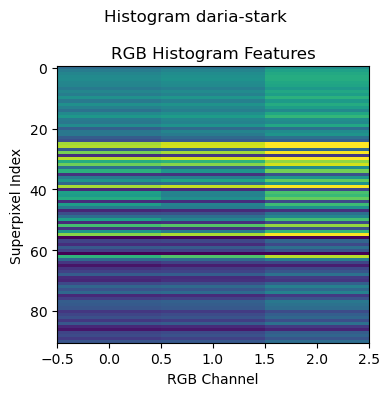

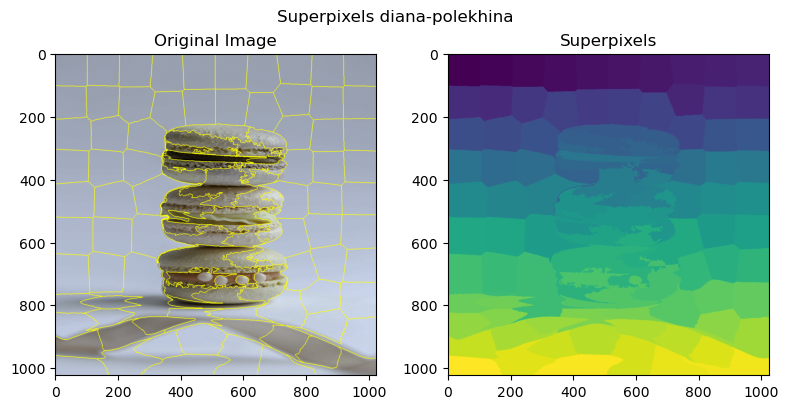

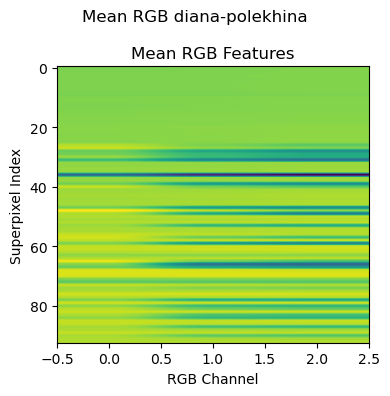

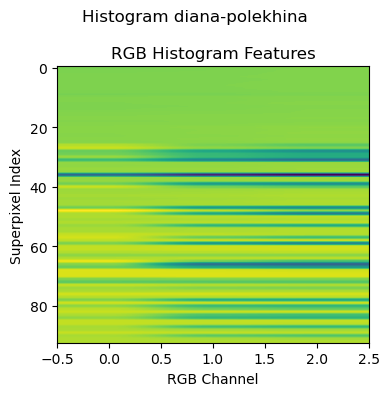

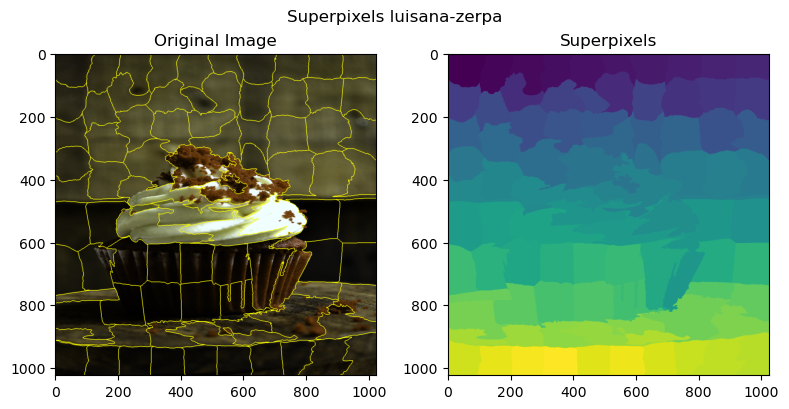

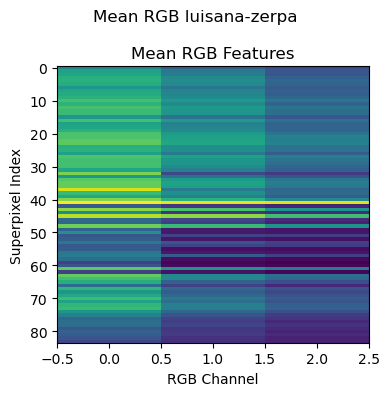

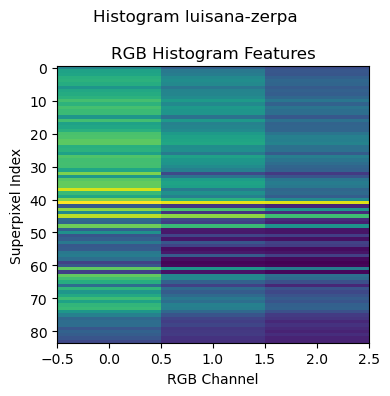

In [105]:
if __name__ == "__main__":
    main()